In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from tqdm import tqdm
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from sklearn.preprocessing import StandardScaler
# import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('resampled_data.csv')
class_counts = df['expert_consensus'].value_counts()
class_perc = class_counts / class_counts.sum()
print(class_perc)

expert_consensus
LPD        0.25
Other      0.25
GPD        0.25
Seizure    0.25
Name: count, dtype: float64


In [3]:
FILTER_CLASS_PERC = True

if FILTER_CLASS_PERC:
    minority_types = class_perc[class_perc < 0.02].index
    df = df[~df['expert_consensus'].isin(minority_types)]
    class_counts = df['expert_consensus'].value_counts()
    class_perc = class_counts / class_counts.sum()
    print(class_perc)
    df.to_csv("filtered_train_less_classes.csv")

expert_consensus
LPD        0.25
Other      0.25
GPD        0.25
Seizure    0.25
Name: count, dtype: float64


In [4]:
def select_random_row(group):
    return group.sample(n=1)

train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min_spec_sec']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max_spec_sec'] = tmp

# this is unnecessary because we don't need patient id to train
consensus_df = df[['eeg_id', 'expert_consensus']].drop_duplicates(subset='eeg_id', keep='first')
train = train.merge(consensus_df, on='eeg_id', how='left')

df_sub_id = df[['eeg_id','eeg_sub_id', 'eeg_label_offset_seconds']]
eeg_with_one_subid = df_sub_id.groupby('eeg_id', as_index=False).apply(select_random_row).reset_index(drop=True)

train = pd.merge(train, eeg_with_one_subid, on='eeg_id', how='left')
train = train.reset_index()

print('Train non-overlapp eeg_id shape:', train.shape)
train.head()

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

Train non-overlapp eeg_id shape: (550, 8)


C:\Users\SatoruGojo\AppData\Local\Temp\ipykernel_15992\2741336498.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eeg_with_one_subid = df_sub_id.groupby('eeg_id', as_index=False).apply(select_random_row).reset_index(drop=True)


In [5]:
def check_overlap(row1, row2):
    if row1['eeg_id']==row2['eeg_id'] and row1['eeg_label_offset_seconds'] < row2['eeg_label_offset_seconds']:
        return True
    return False
#remove overlapping rows belonging to same eeg_id

#REMOVED_OVERLAPS = (True if len(train) < 106800 else False)
REMOVED_OVERLAPS = False
if not REMOVED_OVERLAPS:
    indices_to_remove = []
    for i in range(len(train) - 1):
        row1 = train.iloc[i]
        row2 = train.iloc[i+1]
        if check_overlap(row1, row2):
            indices_to_remove.append(i+1)

    train = train.drop(indices_to_remove).reset_index(drop=True)
    REMOVED_OVERLAPS = True

print(train.shape)

(550, 8)


In [6]:
PATH = 'subset_train_eegs/'

def quantize_data(data, classes):
    data = data-data.mean()
    data = data/(abs(data).max())
    mu_x = mu_law_encoding(data, classes)
    return mu_x

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # TODO: sampling rate
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 40.0
    # Filter a noisy signal.
    # T = 50
    # nsamples = T * fs
    # t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    return y

In [10]:
import random

all_eegs1 = {}
all_eegs2 = {}
for idx in tqdm(range(len(train))):
    row = train.iloc[idx]
    eeg_id = row['eeg_id']
    eeg_sub_id = row['eeg_sub_id']
    parq_path = f'{PATH}{eeg_id}.parquet'
    eeg = pd.read_parquet(parq_path)
    start = int(row['eeg_label_offset_seconds']*200)
    eeg = eeg.iloc[start:start+10000]
    eeg = eeg.fillna(0)
    
    eeg = eeg.drop(['Fz', 'Cz','Pz','EKG'], axis=1)
    signals1 = []
    signals2 = []
    for k in range(4):
            COLS = FEATS[k]

            for j in range(4):
                x = eeg[COLS[j]].values - eeg[COLS[j+1]].values
                x = denoise_filter(x)
                signals1.append(x)
                x = quantize_data(x,1)
                signals2.append(x)
    signals1 = np.array(signals1,dtype='float32')
    signals2 = np.array(signals2,dtype='float32')
    # print("size of quantized signal:")
    # print(signals2.shape)
    

    #modification 4/28: 
    all_eegs1[f'{eeg_id}'] = signals1
    all_eegs2[f'{eeg_id}'] = signals2

# print(all_eegs1)
# print(all_eegs2)

np.save('16_waves_eeg_specs_partial_train',all_eegs1)
np.save('16_waves_eeg_specs_partial_train_quantize',all_eegs2)  #this one is used in training

100%|██████████| 550/550 [00:10<00:00, 54.68it/s]


In [11]:
eeg_ids = train['eeg_id'].astype(str).values

In [12]:
#TODO: check sampling rate


sampling_rate = 256

spectral_densities_dict = {}
spectral_densities = []
spectral_densities_3d = []
for i, eeg_id in enumerate(eeg_ids):
    data = all_eegs2[eeg_id]
    
    freqs, psd = signal.welch(data, fs = sampling_rate)
    spectral_densities_dict[eeg_id] = {'freqs': freqs, 'psd': psd}

    #TODO: original shape of psd is 16*256, corresponding to all 16 channels. had to average for input dim to tsne
    avg_psd = np.mean(psd, axis=0)
    spectral_densities.append(avg_psd)
    spectral_densities_3d.append(psd)
    #plt.semilogy(freqs, psd) 

In [13]:
X = np.array(spectral_densities)
print(X.shape)
X1 = np.array(spectral_densities_3d)



(550, 129)


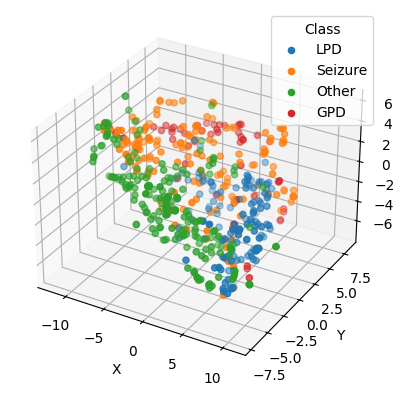

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import mpld3

tsne_3d = TSNE(n_components=3) #2D space
tsne3d_projections = tsne_3d.fit_transform(X)
plotting_df1 = pd.DataFrame(tsne3d_projections, columns=['X','Y','Z'])
plotting_df1['expert_consensus'] = train['expert_consensus']
# sns.scatterplot(x='Dim1', y='Dim2', hue='Dim3', data=plotting_df1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points in 3D with class membership indicated by color
for class_label in plotting_df1['expert_consensus'].unique():
    # Filter points belonging to the current class label
    class_points = plotting_df1[plotting_df1['expert_consensus'] == class_label]
    # Plot points for the current class label
    ax.scatter(class_points['X'], class_points['Y'], class_points['Z'], label=class_label)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(title='Class')

plt.show()

In [18]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score


# Separating features and target
X = plotting_df1[['X', 'Y', 'Z']]
y = plotting_df1['expert_consensus']


svm_classifier = SVC(kernel='rbf')


kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=776)
cv_results = cross_val_score(svm_classifier, X, y, cv=kfold, scoring='accuracy')

print("Accuracy scores for 10-fold cross-validation:")
print(cv_results)
print("Mean cross-validation accuracy:", cv_results.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=165660, stratify=y)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy scores for 10-fold cross-validation:
[0.6        0.70909091 0.69090909 0.72727273 0.65454545 0.67272727
 0.72727273 0.69090909 0.72727273 0.72727273]
Mean cross-validation accuracy: 0.6927272727272727
Accuracy on test set: 0.6636363636363637
Classification Report:
              precision    recall  f1-score   support

         GPD       0.00      0.00      0.00        11
         LPD       0.59      0.73      0.66        26
       Other       0.70      0.78      0.74        40
     Seizure       0.68      0.70      0.69        33

    accuracy                           0.66       110
   macro avg       0.49      0.55      0.52       110
weighted avg       0.60      0.66      0.63       110



c:\Users\SatoruGojo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SatoruGojo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\SatoruGojo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_